# Mean Reversion TIme series and cross-section, with value as Price/moving average, returns as daily log returns, and Futures data 1 (17 commodities, of energy, metals, and agro, from 2004 to late 2019)

In [58]:
import numpy as np
import pandas as pd
from pandas_datareader import DataReader
import datetime as dt
import matplotlib.pyplot as plt

In [376]:
# Price data
data_px = pd.read_excel("FuturesSeries.xlsx", sheet_name= 'Data')


In [377]:
comm = ['WTI','BRENT','NYHarb','NATGAS'] + ['GOLD','SILVER','PLATINUM','PALLADIUM','COPPER','NICKEL'] + ['SOYBEAN','CORN','WHEAT','COFFEE','COTTON','COCOA']
comm_px = data_px[comm]
initial = (comm_px[:3959]).dropna()

In [375]:

cross_list_total_px= ['BRENT','NATGAS','GOLD','COPPER','WHEAT','COCOA','WTI','NYHarb','SILVER','PLATINUM','SOYBEAN','CORN']
# Create asset class data and fill NAs
cross_data_total_px=data_px[cross_list_total_px]
initial = (cross_data_total_px[:3959]).dropna()


In [378]:
from fredapi import Fred
fred = Fred(api_key='7c161acab6738b3fe57d68ce58877860')
CPI = pd.DataFrame(fred.get_series('CPIAUCSL'))
CPI.columns = ['index']

In [379]:

# create index multiplier
CPI['CPI_Multiplier'] = CPI['index'].iloc[-1] / CPI['index']


In [380]:
CPI = CPI.loc[(initial.iloc[0].name).replace(day=1) :]
CPI.head(4)

,index,CPI_Multiplier
2004-01-01,186.3,1.384611
2004-02-01,186.7,1.381644
2004-03-01,187.1,1.378691
2004-04-01,187.4,1.376483


In [381]:
s3 = initial.join(CPI, how='outer')
s3=s3.drop('index',axis=1)
s3['CPI_Multiplier'] = s3['CPI_Multiplier'].fillna(method='ffill')
columns = list(initial.columns) + list(['CPI_Multiplier'])
columns
s3.columns = columns
infl_adjusted = s3[columns].multiply(s3['CPI_Multiplier'], axis="index")
infl_adjusted = infl_adjusted.drop(['CPI_Multiplier'],axis=1)
infl_adjusted = infl_adjusted.dropna()
infl_adjusted.head(5)


,WTI,BRENT,NYHarb,NATGAS,GOLD,SILVER,PLATINUM,PALLADIUM,COPPER,NICKEL,SOYBEAN,CORN,WHEAT,COFFEE,COTTON,COCOA
2004-01-05,46.772154,42.770629,134.085714,9.452738,588.182686,8.630279,1166.534635,283.568301,3301.950707,23811.152662,1103.188689,350.306543,551.767421,94.984304,104.953502,2040.916382
2004-01-06,46.661385,42.673706,135.331864,9.805814,585.967309,8.745202,1178.165366,283.360609,3251.758564,21180.392061,1102.496384,348.229627,546.228977,96.991990,104.773502,2146.146806
2004-01-07,46.550617,42.590630,133.767254,9.523353,584.721159,8.655202,1169.857701,283.499070,3244.835510,21215.007332,1090.381039,346.152711,547.613588,95.330457,102.516587,2273.531004
2004-01-08,47.049076,43.033705,136.259553,9.822429,587.628842,8.669048,1185.919187,282.460612,3337.258284,22371.157386,1098.688704,348.575780,545.536672,94.638151,104.025813,2230.608068
2004-01-09,47.505998,43.435242,139.790311,10.089659,590.951908,8.979201,1183.842271,288.760591,3355.258225,22391.926549,1093.842566,347.537322,533.767480,95.261226,102.696586,2313.684718


In [383]:
def returns(px):
    returns = pd.DataFrame(pd.np.empty((0, len(px.columns))))
    returns.columns = px.columns
    for x in returns.columns:
        returns[x] = np.log(px[x] / px[x].shift(1))
    return returns
    

In [384]:
def time_series_signal_long_and_longshort(px,y):
    ma_df = pd.DataFrame(pd.np.empty((0, len(px.columns))))
    ma_df = px.rolling(window=252*y).mean()
    ma_df.columns = px.columns
    signal_df = pd.DataFrame(pd.np.empty((0, len(px.columns))))
    signal_df.columns = px.columns
    for x in signal_df:
        signal_df[x] = np.where(px[x]<=ma_df[x],1,-1)
    signal_df.index = px.index
    signal_df_long = pd.DataFrame(pd.np.empty((0, len(px.columns))))
    signal_df_long.columns = px.columns
    for x in signal_df_long:
        signal_df_long[x] = np.where(px[x]<=ma_df[x],1,0)
    signal_df_long.index = px.index
    return_long_short = signal_df.shift(1) * returns(px)
    return_long = signal_df_long.shift(1) * returns(px)
    print("TIME SERIES")
    print("LONG_SHORT Returns")       
    print(return_long_short.sum())
    print("TOTAL RETURN  ", return_long_short.sum().sum())
    print("")
    print("LONG ONLY Returns")
    print(return_long.sum())
    print("TOTAL RETURN  ", return_long.sum().sum())


    bench = pd.DataFrame(pd.np.empty((0, len(px.columns))))
    bench.columns = px.columns
    for x in bench.columns:
        bench["Market " +x] = returns(px)[x]
        bench["Long-Short Model "+x] = return_long_short[x] 
        bench["Long Only Model "+x] = return_long[x] 
        fig = bench[["Market " +x,"Long-Short Model "+x,"Long Only Model "+x ]].cumsum().plot(grid=True,figsize=(8,5))
        fig = fig.get_figure()
 
    
    return return_long_short, return_long

TIME SERIES
LONG_SHORT Returns
WTI          1.205362
BRENT        0.325707
NYHarb       0.586074
NATGAS       2.163387
GOLD        -0.736396
SILVER      -1.637371
PLATINUM    -0.606155
PALLADIUM   -0.932198
COPPER       0.996246
NICKEL       2.277025
SOYBEAN     -0.404223
CORN        -0.245826
WHEAT        1.262047
COFFEE      -0.238437
COTTON       1.687946
COCOA        0.526093
dtype: float64
TOTAL RETURN   6.229279591259044

LONG ONLY Returns
WTI          0.702208
BRENT        0.387214
NYHarb       0.504524
NATGAS       0.488154
GOLD         0.031085
SILVER      -0.534664
PLATINUM    -0.466872
PALLADIUM    0.379921
COPPER       0.842877
NICKEL       0.863055
SOYBEAN     -0.302087
CORN        -0.098270
WHEAT        0.525950
COFFEE      -0.108977
COTTON       0.670321
COCOA        0.318457
dtype: float64
TOTAL RETURN   4.202895474199856


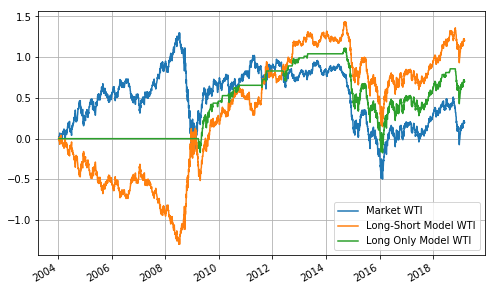

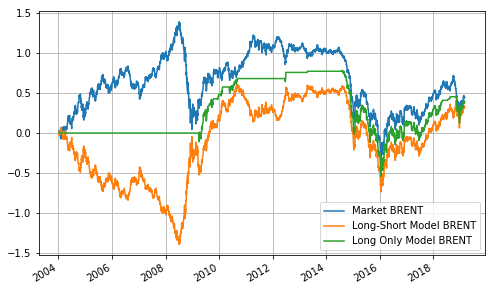

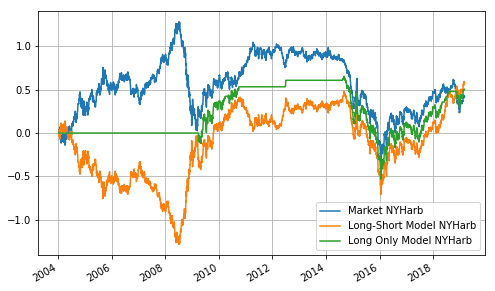

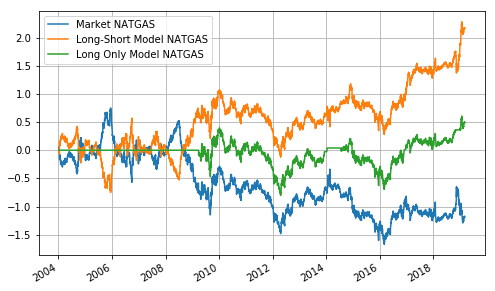

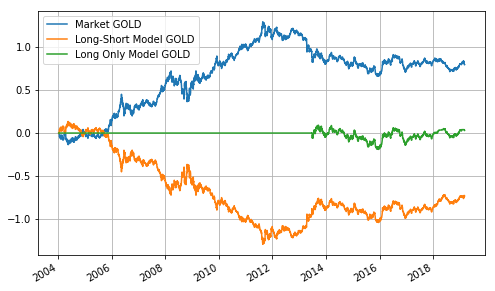

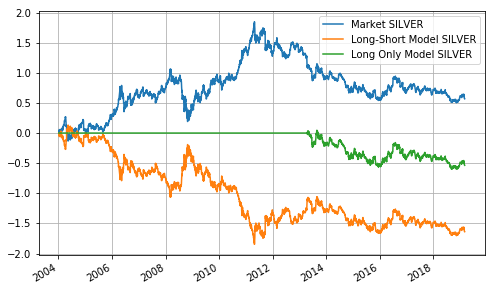

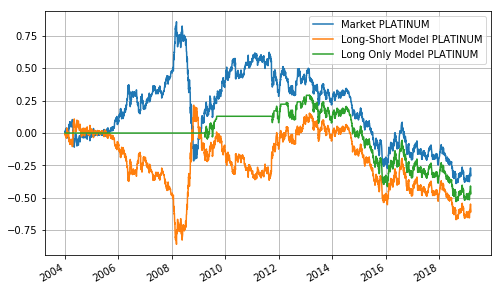

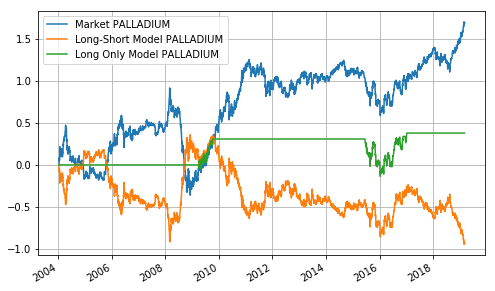

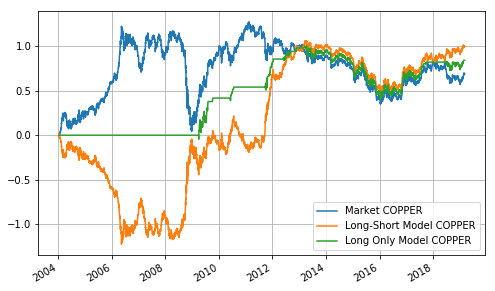

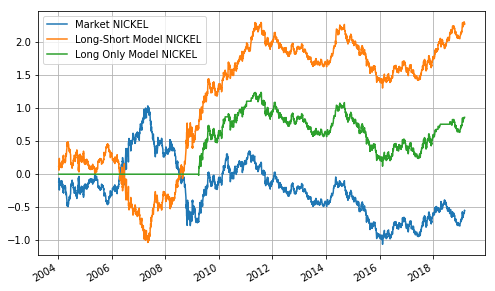

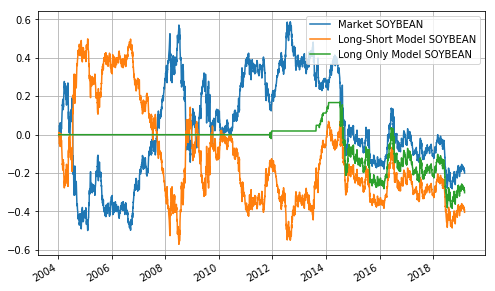

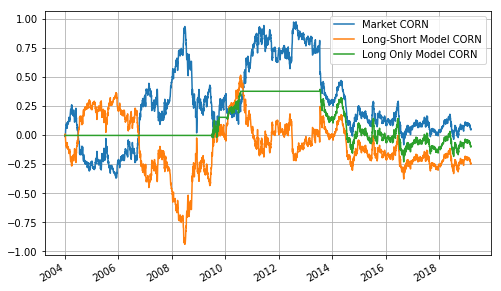

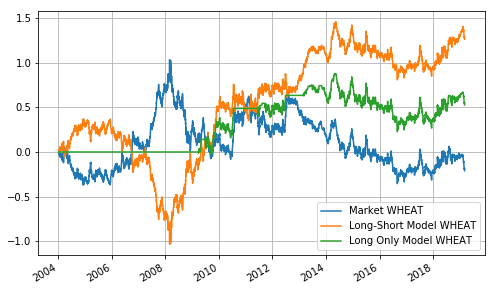

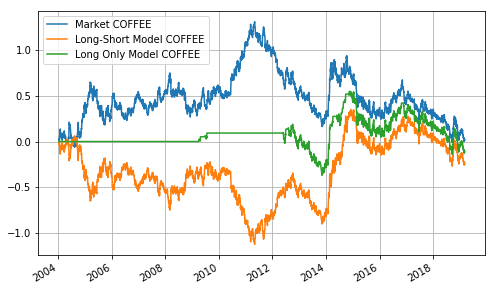

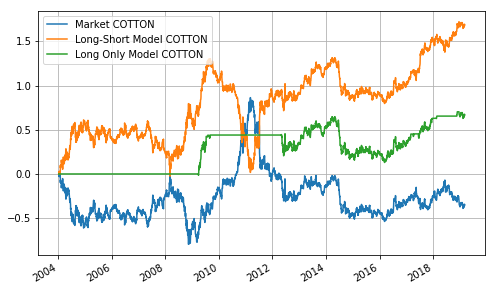

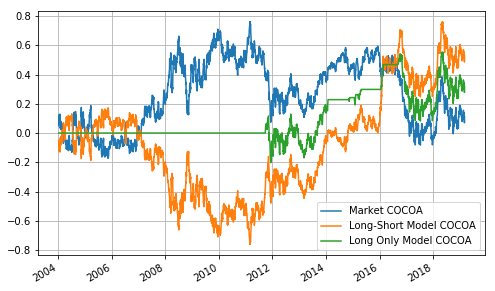

In [385]:
(long_short, long) = time_series_signal_long_and_longshort(infl_adjusted,5)

In [386]:
def cross_section__signal_long_and_longshort(px,y, ):
    cross_ma = pd.DataFrame(pd.np.empty((0, len(px.columns))))
    cross_ma = px / px.rolling(window=256*y).mean()
    cross_ma = cross_ma.dropna()
    cross_ma.columns = px.columns
    ranks = cross_ma.rank(axis=1, ascending=False)
    ranks.index = cross_ma.index
    
    signal_df_long_short = pd.DataFrame(index=ranks.index,columns = ranks.columns )
    for x in ranks.index:
        signal_df_long_short.loc[x] = np.where(ranks.loc[x]<int(len(px.columns)/3)+1,-1,0)
        signal_df_long_short.loc[x] = np.where(ranks.loc[x]>int(len(px.columns)/3)*2,1, signal_df_long_short.loc[x])
    signal_df_long_short.index = cross_ma.index
    
    signal_df_long = pd.DataFrame(index=ranks.index,columns = ranks.columns )
    for x in ranks.index:
        signal_df_long.loc[x] = np.where(ranks.loc[x]>int(len(px.columns)/3)*2,1, 0)
    signal_df_long.index = cross_ma.index
    
    return_long_short = signal_df_long_short.shift(1) * returns(px)
    return_long = signal_df_long.shift(1) * returns(px)
    print("CROSS SECTION")
    print("LONG_SHORT Returns")       
    print(return_long_short.sum())
    print("TOTAL RETURN  ", return_long_short.sum().sum())
    print("")
    print("LONG ONLY Returns")
    print(return_long.sum())
    print("TOTAL RETURN  ", return_long.sum().sum())


    bench = pd.DataFrame(pd.np.empty((0, len(px.columns))))
    bench.columns = px.columns
    for x in bench.columns:
        bench["Market " +x] = returns(px)[x]
        bench["Long-Short Model "+x] = return_long_short[x] 
        bench["Long Only Model "+x] = return_long[x] 
        fig = bench[["Market " +x,"Long-Short Model "+x,"Long Only Model "+x ]].cumsum().plot(grid=True,figsize=(8,5))
        fig = fig.get_figure()
 
    
    return return_long_short, return_long

CROSS SECTION
LONG_SHORT Returns
WTI          1.333297
BRENT        1.424847
NYHarb       1.553933
NATGAS       2.639809
GOLD        -0.269430
SILVER      -0.816944
PLATINUM     0.306871
PALLADIUM   -0.425422
COPPER       0.492070
NICKEL       0.983188
SOYBEAN      0.595141
CORN         0.970758
WHEAT        1.266488
COFFEE       1.326132
COTTON      -0.322438
COCOA        0.485051
dtype: float64
TOTAL RETURN   11.543349451031467

LONG ONLY Returns
WTI          1.012927
BRENT        0.852275
NYHarb       0.885331
NATGAS       0.761188
GOLD         0.012811
SILVER      -0.258574
PLATINUM     0.051841
PALLADIUM    0.277782
COPPER       0.197711
NICKEL       0.665097
SOYBEAN      0.244196
CORN         0.375034
WHEAT        0.481080
COFFEE      -0.051527
COTTON      -0.028168
COCOA        0.286011
dtype: float64
TOTAL RETURN   5.765014337244768


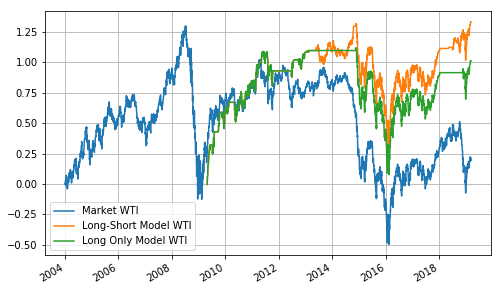

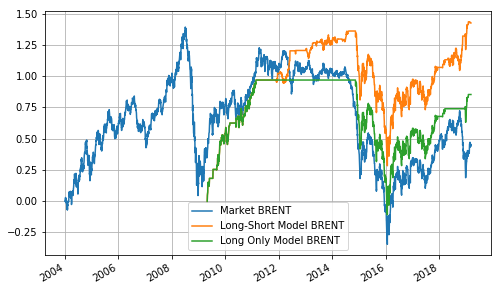

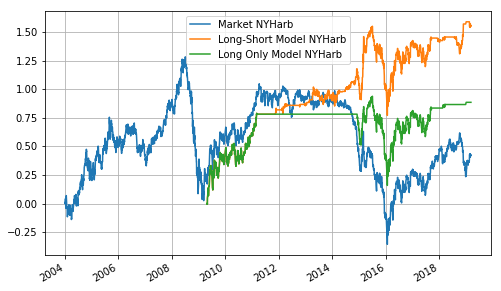

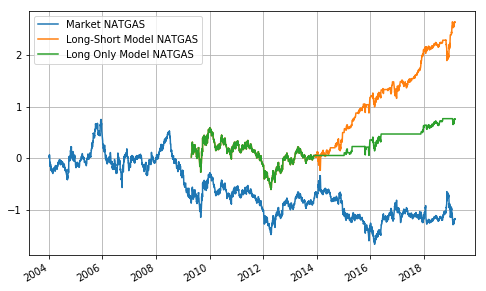

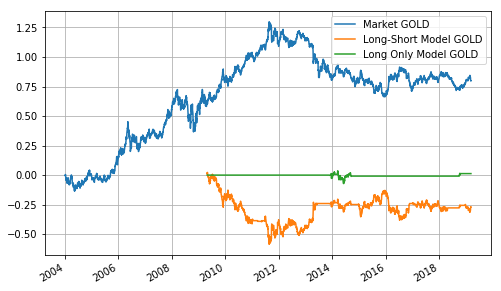

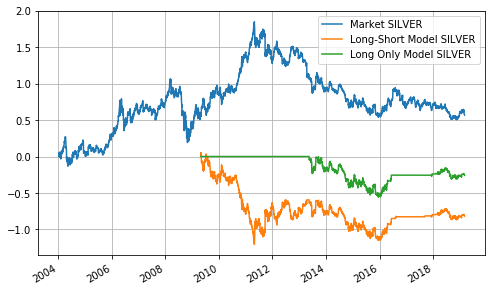

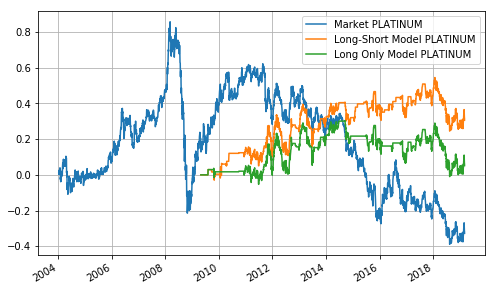

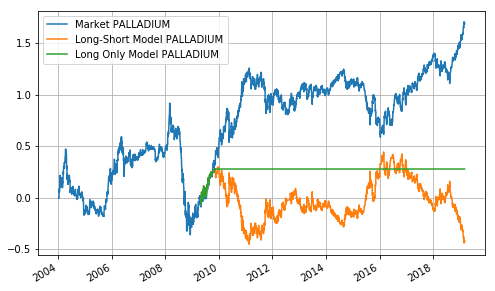

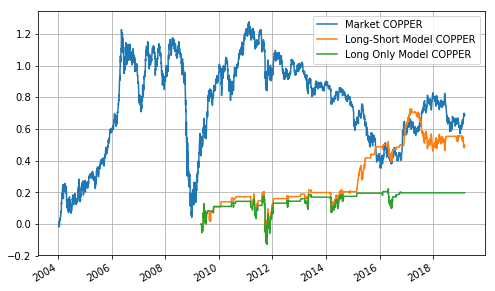

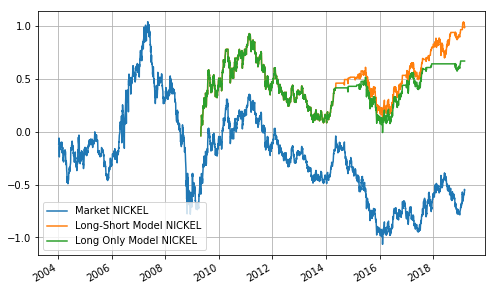

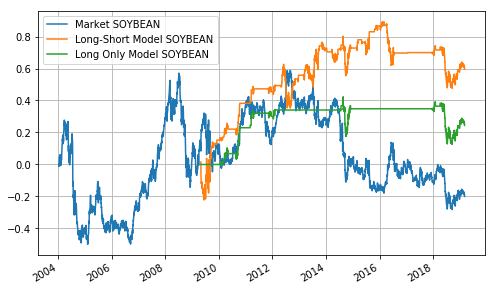

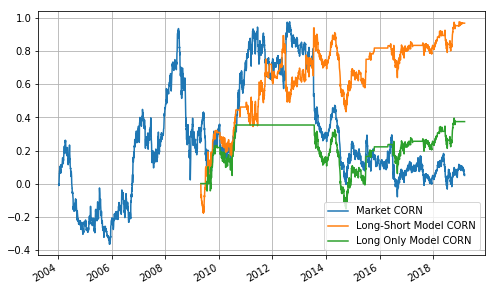

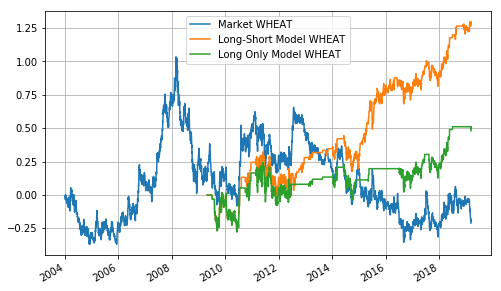

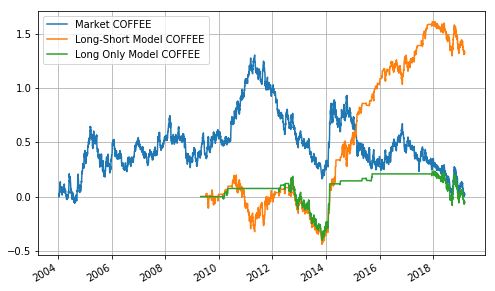

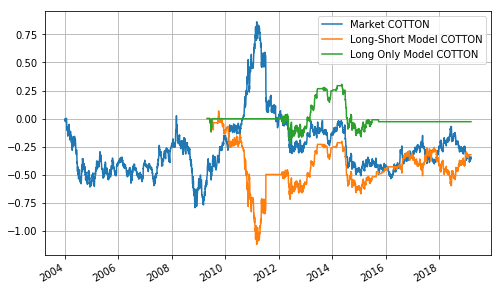

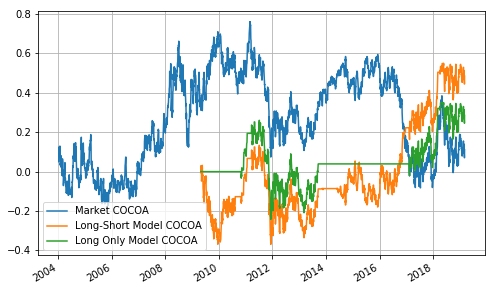

In [387]:
(long_short, long) = cross_section__signal_long_and_longshort(infl_adjusted,5)

In [ ]:
#by adding ['NICKEL', 'COFFEE', 'PALLADIUM', 'COTTON'], total return was improved

In [397]:
#y=months

def heat_cross_section__signal_long_and_longshort(px,y, f):
    cross_ma = pd.DataFrame(pd.np.empty((0, len(px.columns))))
    cross_ma = px / px.rolling(window=21*y).mean()
    cross_ma = cross_ma.dropna()
    cross_ma.columns = px.columns
    ranks = cross_ma.rank(axis=1, ascending=False)
    ranks.index = cross_ma.index
    
    signal_df_long_short = pd.DataFrame(index=ranks.index,columns = ranks.columns )
    for x in ranks.index:
        signal_df_long_short.loc[x] = np.where(ranks.loc[x]<int(len(px.columns)*f),-1,0)
        signal_df_long_short.loc[x] = np.where(ranks.loc[x]>int(len(px.columns)*(1-f)),1, signal_df_long_short.loc[x])
    signal_df_long_short.index = cross_ma.index
    

    
    return_long_short = signal_df_long_short.shift(1) * returns(px)


    r = return_long_short.sum().sum()


    return r

In [398]:
import numpy as np
from collections import defaultdict
months = range(12, 60, 6) 
weight = np.arange(0.1, 1, 0.1)
dd = defaultdict(dict)
for y in months:
    for f in weight:
        dd[y][f] = heat_cross_section__signal_long_and_longshort(infl_adjusted,y, f)
        ddf = pd.DataFrame(dd)
        ddf.index.name = 'Signal Weight' 
        ddf.columns.name = 'Lookback Period in Months'

In [399]:
import matplotlib.pyplot as plt
def heatmap(df, cmap=plt.cm.hot):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    axim = ax.imshow(df.values, cmap=cmap, interpolation='nearest') 
    ax.set_xlabel(df.columns.name) 
    ax.set_xticks(np.arange(len(df.columns))) 
    ax.set_xticklabels(list(df.columns)) 
    ax.set_ylabel(df.index.name) 
    ax.set_yticks(np.arange(len(df.index))) 
    ax.set_yticklabels(list(df.index))
    plt.colorbar(axim)

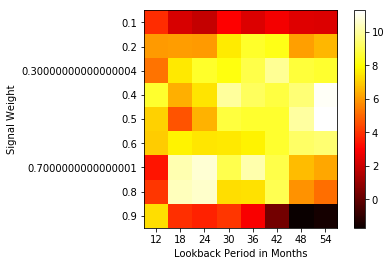

In [400]:
heatmap(ddf)